## Student: Tornike Onoprishvili   
## Exercise 5. `PyTorch on GPUs`

All tasks are in this single notebook.

In [1]:
from math import ceil as roof # Very important!
import numpy as np
import torch

assert torch.cuda.is_available()

## Task 1:

PyTorch tensors can be created by constructors or using conversions from other types of arrays. They can be directly created on a desired device or copied from one device to another.

Experiment with PyTorch tensors as follows:

-    Prepare startup code for allowing CPU and GPU execution.
-    Create one 3D tensor of size 128^3 to the main memory (CPU) and another to the GPU memory. The tensor elements should be double precision (64-bit) floating point numbers that are sampled from the normal probability distribution with zero mean and unit variance. Determine how much memory each tensors reserves.
-    Perform matrix multiplication on the GPU with the tensors and serialise the result to storage.
-    If possible, examine the memory utilisation on the GPU while varying the tensor sizes. Does the information reflect the true utilisation of memory?

Hints: device, element_size, nelement, to, empty_cache.

In [2]:
print('Max total device mem', torch.cuda.get_device_properties(0).total_memory / 1e9)
print("Device", torch.cuda.get_device_properties(0))

Max total device mem 8.36173824
Device _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070 with Max-Q Design', major=7, minor=5, total_memory=7974MB, multi_processor_count=36)


In [3]:
device = 'cuda'

# To get the storage requirements
nbytes = lambda ten: ten.numel() * ten.element_size()

# Our tensor (CPU)
ten = torch.randn(128, 128, 128, dtype=torch.float64)

# Normal matmul doesn't make much sense here - I instead use batch-matrix multiply.
bmm = torch.bmm(ten, ten)

torch.save(bmm, 'bmm_result.pt')

# Report mem usage
print(f"ten size {nbytes(ten) / 1e9} GB")
print(f"bmm(ten, ten) size {nbytes(bmm) / 1e9} GB")
print("Alloc ", torch.cuda.memory_allocated()/1e9)
print("Reserved ", torch.cuda.memory_reserved()/1e9)
print("Max reserved ", torch.cuda.max_memory_reserved()/1e9)

ten size 0.016777216 GB
bmm(ten, ten) size 0.016777216 GB
Alloc  0.0
Reserved  0.0
Max reserved  0.0


In [4]:
! nvidia-smi

Fri Feb 16 13:16:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    24W /  80W |      8MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Let's make a tensor of large size of size 200mb

large_ten = torch.zeros(200_000_000 // 4, dtype=torch.float32)
large_ten = large_ten.to(device)

! nvidia-smi

Fri Feb 16 13:16:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    24W /  80W |    722MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
print(f"Expected mem usage (GB) {nbytes(large_ten)*1e-9}")

Expected mem usage (GB) 0.2


We can see that memory usage is a lot higher (714mb vs 200mb) than what we requested. This means that the actualy memory usage can't be easily determined using nvidia-smi. 

## Task 2

A neural network (NN) is a machine learning model consisting of layers of neurons and nonlinearities in the form of activation functions. In the simplest form, only a single hidden layer is used in addition to the input and output layers. These models are typically trained in the supervised manner so that the desired outputs are known the each input. The training adjusts iteratively the model parameters, that is, the neuron weights and biases, and the model architecture and the training process are affected by hyperparameters.

Implement a NN with PyTorch. Take into account the following:

-    Define the loss function according to the task.
-    Use automatic differentiation (autograd) in the training loop.
-    Select the hyperparameters so that the model is as simple as possible for solving the task in a reasonable way (Ockham's razor) and the training converges.
-    Train the model with the given data and show that it works.

Hints: autograd, nn.

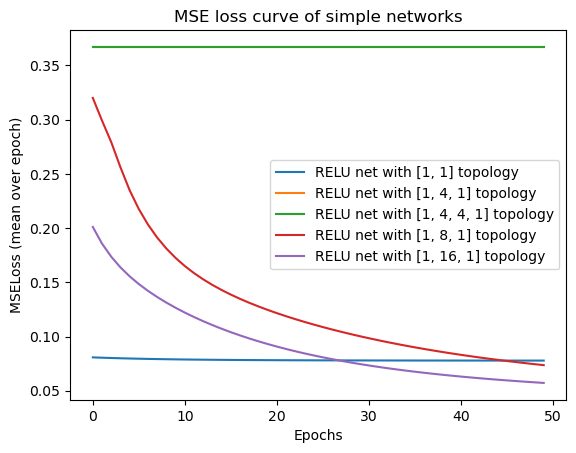

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

df = pd.read_csv('t005b.csv', header=None)
data_ten = torch.tensor(df.to_numpy(), dtype=torch.float32)

ten_ds = TensorDataset(data_ten[:, 0].unsqueeze(1), data_ten[:, 1].unsqueeze(1))
ten_dl = DataLoader(ten_ds, 4)

class Network(nn.Module):
    def __init__(self, topo = [1,4,1]) -> None:
        super().__init__()
        stack = []
        for a,b in zip(topo, topo[1:]):
            stack.append(nn.Linear(a,b,bias=True))
            stack.append(nn.ReLU())
        self.stack = nn.Sequential(*stack)
    def forward(self, x):
        x = self.stack(x)
        return x
    
data_ten

for topo in [ [1,1], [1,4,1], [1,4,4,1], [1,8,1], [1,16,1] ]:
    net = Network(topo=topo)
    opt = torch.optim.SGD(net.parameters(), lr=5e-3)
    epochs = 50
    hist_loss = []
    for ep in range(epochs):
        ep_loss = 0
        for bx, by in ten_dl:
            by_pred = net(bx)
            loss = F.mse_loss(by_pred, by)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_loss += loss.item() / len(ten_dl)
        hist_loss += [ep_loss]
        
    plt.plot(hist_loss, label=f'RELU net with {topo} topology')
    plt.xlabel("Epochs")
    plt.ylabel("MSELoss (mean over epoch)")
    plt.title(f"MSE loss curve of simple networks")
    plt.legend()
plt.show()

## Task 3

PyTorch offers a comprehensive selection of mathematical operators on tensors. These operations can be executed on a CPU or a GPU, and many of the operations are much faster on a GPU.

Experiment with PyTorch tensor operations as follows:

- Prepare startup code for allowing both CPU and GPU execution.
- Create a reasonably large 2D tensor of random numbers to the main memory (CPU) and another one of the same size to the GPU memory.
- Perform eigenvalue decomposition of the tensors and compare the execution times of both cases so that the measurement is performed properly.

Hints: torch.linalg, torch.cuda.Event, torch.cuda.synchronize.

In [49]:
import torch
import time

# Function to measure execution time
def measure_execution_time_cuda(func):
    dur = 0
    for _ in range(3):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        func()
        end.record()
        # Waits for everything to finish running
        torch.cuda.synchronize()
        dur += start.elapsed_time(end)
        
    return (dur/1000) / 3

def measure_execution_time(func):
    dur = 0
    for _ in range(3):
        dur -= time.perf_counter()
        func()
        dur += time.perf_counter()
    return dur / 3


# Function to perform eigenvalue decomposition
def eigenvalue_decomposition(tensor):
    eigenvalues, _ = torch.linalg.eig(tensor)
    return eigenvalues

# Prepare startup code for allowing both CPU and GPU execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create a reasonably large 2D tensor of random numbers
size = (4096, 4096)
tensor_cpu = torch.randn(size, device="cpu")
tensor_gpu = torch.randn(size, device="cuda")

# Perform eigenvalue decomposition of the tensors and measure execution time
cpu_execution_time = measure_execution_time(lambda: eigenvalue_decomposition(tensor_cpu))
gpu_execution_time = measure_execution_time_cuda(lambda: eigenvalue_decomposition(tensor_gpu))

print("CPU Execution Time:", cpu_execution_time)
print("GPU Execution Time:", gpu_execution_time)

Device: cuda
CPU Execution Time: 12.308515906000443
GPU Execution Time: 7.406593912760417
